In [2]:
import numpy as np
import pandas as pd
from collections import OrderedDict
from pyvstim import utils as parse
from glob import glob
from os.path import join as pjoin
import os
from datetime import datetime as dt 
from datetime import timedelta 
from collections import OrderedDict
import pylab as plt
import json
%matplotlib inline    

In [38]:
area_colors = dict(AL='tab:orange',
                   PM='tab:blue')

def fit2sigmoid(xdata,ydata,resolution=100):
    from scipy.optimize import curve_fit
    '''
    L = max value of sigmoid
    k = logistic growth rate aka steepness
    '''
    sigmoid = lambda x, L, k ,b: L / (1.0 + np.exp(-k*(x))) + b
    
    p0 = [np.max(ydata),0,np.min(ydata)] #initial guesses for parameters
    popt, pcov = curve_fit(sigmoid, 
                           xdata, 
                           ydata,
                           p0,
                           method='dogbox')

    
    x_fitted = np.linspace(xdata.min(),xdata.max(),resolution).reshape(-1,1)
    y_fitted = np.asarray(sigmoid(x_fitted, *popt)).reshape(-1,1)
    ret = np.concatenate((x_fitted,y_fitted),axis=1)
    
    return ret

def get_turning_points(x):
    N = 0
    for i in range(1,len(x)-1):
        if x[i-1]<x[i] and x[i+1]<x[i]:
            N +=1
        elif x[i-1]>x[i] and x[i+1]>x[i]:
            N+=1
    return N

def parsePref(preffile):
    with open(preffile, 'r') as infile:
        pref = json.load(infile)
        return pref

In [44]:
# reaction times for each contrast with respect to trials
# wheel trajectories
# trials per minute in a session
class WheelSession():
    def __init__(self,sessiondir,animalid=None,verbose=False,autoanalyse=False):
        self.sessiondir = sessiondir
        self.verbose = verbose
        if animalid is None:
            self.animalid = self.sessiondir.split('_')[1]
        else:
            self.animalid = animalid
        self.logpath = pjoin(self.sessiondir,[x for x in os.listdir(self.sessiondir) if '.log' in x][0])
        self.protpath = pjoin(self.sessiondir,[x for x in os.listdir(self.sessiondir) if '.prot' in x][0])
        self.prefpath = pjoin(self.sessiondir,[x for x in os.listdir(self.sessiondir) if '.prefs' in x][0])
        
        self.data,self.comments = parse.parseVStimLog(self.logpath)
        self.stimopt, self.stimpar = parse.parseProtocolFile(self.protpath)
        self.metadata()
        
        if autoanalyse:
            self.get_session_data()
            if verbose:
                print(self.get_session_summary())
            self.plot_session()
            
    def session_user(self,parsepath):
        import json
        with open(parsepath,'r') as f:
            x=json.load(f)
            if 'userPrefix' in x.keys():
                return x['userPrefix']
            else:
                print('No user found')
                return -1   
            
    def metadata(self):
        #get metadata
        self.date = dt.strftime(dt.strptime(self.sessiondir.split('/')[-1].split('_')[0],'%y%m%d').date(),'%d %b %y')
        runname = [x.split(':')[1] for x in self.comments if 'Filename' in x][0].split('.')[0].strip(' ')
        starttime = self.comments[2].split('-')[-1].strip(' ')
        self.user = self.session_user(self.prefpath)
        runtime = self.data['vstim'].iloc[-1]['presentTime']/1000 #seconds
        
        p = parsePref(self.prefpath)
        self.rig = p['tmpFolder'].split('\\')[-1]
        
        self.metadata = dict(date = self.date,
                            starttime = starttime,
                            user = self.user,
                            rig = self.rig,
                            runtime = runtime,
                            runname = runname)
        if self.verbose:
            print('''---Session {0}---\nAnimal ID : {1}\nDate: {2}\nUser : {3}\nDuration:\n
            '''.format(self.runname,self.animalid,self.date,self.user))
            
    #CURRENTLY ONLY FOR CORRECT AND INCORRECT ANSWERS
    def get_confidence(self):
        legit_answer_df = self.session_data[self.session_data['answer']!=-1]
        confidence_dict = {}
        for i,row in legit_answer_df.iterrows():
            
            nturns = get_turning_points(row['stim_pos'])
            confidence_index = 1-(nturns/len(row['stim_pos']))
            confidence_dict[row['trial_no']] = [row['contrast'],confidence_index]
            
        return confidence_dict
        
    def get_trial_data(self,trial_slice):
        #transition keys
        trialstart = '0->1'
        openloopstart = '1->2'
        closedloopstart = '2->3'
        earlyanswer = '2->5'
        correct = '3->4'
        incorrect = '3->5'
        nonanswer = '3->7'
        trialend = '6->0'
        correction = '7->1'
        
        firststimflag = False
        trial_row = {'trial_no':int(trial_slice['iStim'].iloc[0])}
        trial_row['correction_count'] = 0
        trial_row['early_times'] = []
        for index, row in trial_slice.iterrows():
            transition_key = '{0}->{1}'.format(int(row['iFrame']),int(row['iTrial']))
            #trial start
            if transition_key == trialstart:   
                trial_row['trial_start'] = row['presentTime']
                firststimflag = True

            #trial end
            elif transition_key == trialend:
                trial_row['trial_end'] = row['presentTime']

            #stim start
            elif transition_key == openloopstart:
                if firststimflag:
                    trial_row['openloopstart'] = row['presentTime']  
            
            #move start
            elif transition_key == closedloopstart:
                if firststimflag:
                    trial_row['closedloopdur'] = [row['presentTime']]

            #early
            elif transition_key == earlyanswer:
                trial_row['early_times'].append(row['blank'])
                  
            #correct    
            elif transition_key == correct:
                #trials first decision
                if firststimflag:
                    trial_row['response_latency'] = row['blank']
                    trial_row['answer'] = 1
                    trial_row['closedloopdur'].append(row['presentTime'])
                    firststimflag = False

            #incorrect
            elif transition_key == incorrect:
                #trials first decison
                if firststimflag:
                    trial_row['response_latency'] = row['blank']
                    trial_row['answer'] = 0
                    trial_row['closedloopdur'].append(row['presentTime'])
                    firststimflag = False

            #non answer
            elif transition_key == nonanswer:
                #trials first decision
                if firststimflag:
                    trial_row['response_latency'] = row['blank']
                    trial_row['answer'] = -1
                    trial_row['closedloopdur'].append(row['presentTime'])
                    firststimflag = False

            #correction
            elif transition_key == correction:
                trial_row['correction_count'] += 1
                
        return trial_row
        
    def get_session_data(self):
        print('Getting Session Data for {0} in {1}'.format(self.animalid,self.date))
        
        session_data = pd.DataFrame()
        self.states = self.data['stateMachine']
        
        if self.states.shape[0] is 0:
            print('No state machine data to analyze, logging is problematic...')
            return -1
        
        trials = np.unique(self.states.iStim)
        correct_count = 0
        for t in trials:
            trial_slice = self.states[self.states['iStim'] == t]
            trial_row = self.get_trial_data(trial_slice)
            
            if 'answer' not in trial_row.keys():
                # THIS MIGHT BRAKE THINGS
                # this shouldn't happen, happens if trial stopped midway, discard the trial
                trial_row = None
                print('Removing floating trial no {0}. '.format(t))
                continue
            else:
                if trial_row['answer'] is 1:
                    correct_count += 1
                trial_row['running_percent'] = 100*correct_count/t 
                
            #from the trial_row start and end times, get contrast, stim side, wheel movement and licks
            
            if trial_row is not None:
                    
                # if trial_end is not present
                if 'trial_end' not in trial_row.keys():
                    trial_row['trial_end'] = trial_slice['presentTime'].iloc[-1]

                vstim = self.data['vstim']
                t_stimstart = trial_row['openloopstart']
                t_movestart = trial_row['closedloopdur'][0]
                t_stimend = trial_row['closedloopdur'][1]
                
                vstim_interval = vstim[(vstim['presentTime'] >= t_stimstart) & (vstim['presentTime'] <= t_stimend)].dropna()

#                 if len(np.unique(vstim_interval['iFrame'])) > 1:
#                     print('MULTIPLE CONTRAST VALUES IN SINGLE TRIAL! SOMETHING IS WRONG!!')
                    
                #get contrast
                trial_row['contrast'] = vstim_interval['iFrame'].iloc[0]
                
                #get sftf
                trial_row['spatial_freq'] = vstim_interval['blank'].iloc[0]
                trial_row['temporal_freq'] = vstim_interval['contrast'].iloc[0]

                #get stim side
                trial_row['stim_side'] = vstim_interval['iTrial'].iloc[0]

                #get stim movement
                trial_row['stim_pos'] = np.asarray(vstim_interval['iTrial'])

                #add wheel 
                wheel = self.data['position']
                wheel_interval = wheel[(wheel['duinotime'] >= t_stimstart) & (wheel['duinotime'] <= t_stimend)].dropna()

                trial_row['wheel'] = np.asarray(wheel_interval[['duinotime','value']])
                #add lick
                lick = self.data['lick']
                lick_interval = lick[(wheel['duinotime'] >= t_stimstart) & (lick['duinotime'] <= t_stimend)].dropna()
                if len(lick_interval) is 0:
                    #no lick detected, might be an issue with detection or headplate on mice
                    trial_row['lick'] = 0
                else:
                    trial_row['lick'] = np.asarray(lick_interval[['duinotime','value']])
                
                #add opto
                opto = self.data['opto']
                opto_interval = opto[(opto['duinotime'] >= t_stimstart) & (opto['duinotime'] <= t_stimend)].dropna()
                if len(opto_interval) is 0:
                    #no opto stim in this trial
                    trial_row['opto'] = 0
                else:
                    trial_row['opto'] = 1
                    
                session_data = session_data.append(trial_row,ignore_index=True)
        
        if session_data.empty:
            print('''WARNING THIS SESSION HAS NO DATA
            Possible causes:
            - Session has only one trial with no correct answer''')
        else:
            self.session_data = session_data
            self.session_summary = self.get_session_summary()
            
    def get_session_summary(self):
        reward_amount = 1.5 #uL
        s=self.session_data[self.session_data['answer']!=-1]
        if not s.empty:
            answered_trials = s.shape[0]
            all_trials = self.session_data.shape[0]
            total_latency = np.sum(s['response_latency'])
            
            
            #corrects
            correct_trials = s[s['answer']==1]
            correct_count = float(correct_trials.shape[0])
            
            #incorrects
            incorrect_trials = s[s['answer']==0]
            incorrect_count = incorrect_trials.shape[0]
            
            #contrast bias
            all_contrast = np.unique(s['contrast'])
            all_freq = np.unique(s['spatial_freq'])
            bias_dict = {}
            trial_dstr = {}
            bino_dict = {}
            for freq in all_freq:
                if freq == 0.4:
                    key = 'PM'
                elif freq == 0.05:
                    key = 'AL'
                else:
                    key = 'V1' 
#                 trial_dstr[key]=[]
                trial_dstr[key] = 0
                freq_df = s[s['spatial_freq']==freq]
                contrast_bias = pd.DataFrame()
                contrast_binomial = pd.DataFrame()
                for i,c in enumerate(all_contrast):
                    
                    contrast_left_df = freq_df[(freq_df['contrast']==c) & (freq_df['stim_side']==-25)]
                    
                    #stim on left
                    if len(contrast_left_df):
                        incorrectly_right = contrast_left_df[contrast_left_df['answer']==0]
                        percent_right_left = len(incorrectly_right) / len(contrast_left_df)
                        bino_right_left = 1.96 * np.sqrt((percent_right_left*(1-percent_right_left))/len(contrast_left_df)) # 95% binomial 
                    else:
                        percent_right_left = 0
                        bino_right_left = 0
                        
                        
                    contrast_right_df = freq_df[(freq_df['contrast']==c) & (freq_df['stim_side']==25)]
                    #stim on right
                    if len(contrast_right_df):
                        correctly_right = contrast_right_df[contrast_right_df['answer']==1]
                        percent_right_right = len(correctly_right) / len(contrast_right_df)
                        bino_right_right = 1.96 * np.sqrt((percent_right_left*(1-percent_right_left))/len(contrast_left_df)) # 95% binomial 
                    else:
                        percent_right_right = 0
                        bino_right_right = 0
                        
                    trial_dstr[key] += (contrast_left_df.shape[0]+contrast_right_df.shape[0])
                        
                    tmp = np.asarray([percent_right_left, percent_right_right])
                    bino_tmp = np.asarray([bino_right_left, bino_right_right])
                    contrast_bias.insert(i,c,tmp)
                    contrast_binomial.insert(i,c,bino_tmp)
                    
#                     tmp = {c:[contrast_left_df.shape[0],contrast_right_df.shape[0]]}
#                     trial_dstr[key].append(tmp)
                    
                bias_dict[key] = contrast_bias
                bino_dict[key] = contrast_binomial
            
            return dict(metadata = self.metadata,
                        all_trials = all_trials,
                        answered_trials = answered_trials,
                        trial_dstr = trial_dstr,
                        correct_percent = self.session_data['running_percent'].iloc[-1],
                        avg_latency = total_latency / answered_trials,
                        bias = bias_dict,
                        bino = bino_dict)
        else:
            return {}
        

    def plot_session(self,savefig=False,plot_params=dict(fig_size=(15,15),
                                           font_size=20,
                                           title_size=23,
                                           line_width=8,
                                           bar_width=0.15,
                                           marker_size=10)):
        
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=plot_params['fig_size'])
        trial_no = self.session_data['trial_no']
        correct_percent = self.session_data['running_percent']
        response_latency = self.session_data['response_latency']
        
        # correct_percent and response_latency
        ax1=axes[0]
        ax1.plot(trial_no,
                 correct_percent,
                 'darkgreen',
                 marker='o',
                 markersize=plot_params['marker_size'],
                 label='Correct Response Time(ms)',
                 linewidth=plot_params['line_width'])
        ax1.set_xlabel('Trial No',fontsize = plot_params['font_size'])
        ax1.set_ylabel('Correct Percent',fontsize = plot_params['font_size'])
        
        ax12 = ax1.twinx()
        ax12.plot(trial_no,
                  response_latency/float(1000),
                  'royalblue',
                  marker='o',
                  markersize=plot_params['marker_size'],
                  label='Average Response Time(s)',
                  linewidth=plot_params['line_width'])
        ax12.set_ylabel('Response Time(ms)',fontsize = plot_params['font_size'])
        ax12.set_ylim([0,50])
        
        ax1.set_title('Performance',fontsize=plot_params['title_size'])
        ax1.grid(b=True)
        ax1.tick_params(labelsize=plot_params['font_size'])
        ax12.tick_params(labelsize=plot_params['font_size'])
        
       #correction per contrast and correction per side 
        contrast_list = np.unique(self.session_data['contrast'])
#         ax2 = axes[0,1]
#         ax2.set_xticks(contrast_list)
        
#         for i,c in enumerate(contrast_list):
#             contrast_dict = self.session_data[self.session_data['contrast']==c]
#             corr_count_left = np.sum(contrast_dict[contrast_dict['stim_side']==-25.0]['correction_count'])
#             corr_count_right = np.sum(contrast_dict[contrast_dict['stim_side']==25.0]['correction_count'])
            
#             bar_loc=plot_params['bar_width']/2
#             ax2.bar(c-bar_loc,corr_count_left,plot_params['bar_width'], color='orange',label='Left')
#             ax2.bar(c+bar_loc,corr_count_right,plot_params['bar_width'], color='royalblue',label='Right')
        
#         ax2.grid(b=False)
#         ax2.set_title('Correction',fontsize=plot_params['title_size'])
#         ax2.set_xlabel('Contrast Value',fontsize = plot_params['font_size'])
#         ax2.set_ylabel('Correction Count',fontsize = plot_params['font_size'])
#         ax2.tick_params(labelsize=plot_params['font_size'])
#         ax2.legend(loc = [0.07,0.75],fontsize = 12,borderpad=0.1, labelspacing=0.4,prop={'size': 14})

        #psychometric graph
        ax3=axes[1]
        neg_contrast = [-1*c for c in contrast_list]
        contrast_axis = 100*np.unique(np.hstack((neg_contrast[::-1],contrast_list)))
        contrast_correct = np.zeros_like(contrast_axis)
        contrast_bino = np.zeros_like(contrast_axis)
        marker_size = np.copy(contrast_correct)

        for k in self.session_summary['bias'].keys():
            for i,c in enumerate(contrast_list[::-1]):
                # this is the left
                marker_size[i] = len(self.session_data[(self.session_data['contrast']==c) & (self.session_data['stim_side']==-25)])
                contrast_correct[i] = self.session_summary['bias'][k][c].iloc[0]
                contrast_bino[i] = self.session_summary['bino'][k][c].iloc[0]
                
                #this is the right
                marker_size[-i-1] = len(self.session_data[(self.session_data['contrast']==c) & (self.session_data['stim_side']==25)])
                contrast_correct[-i-1] = self.session_summary['bias'][k][c].iloc[1]
                contrast_bino[-i-1] = self.session_summary['bino'][k][c].iloc[1]
        
            fitted = fit2sigmoid(contrast_axis,contrast_correct)
            ax3.plot(fitted[:,0],fitted[:,1],
                     linewidth=plot_params['line_width'])
                     
            ax3.errorbar(contrast_axis,contrast_correct,contrast_bino,
                         marker='o',
                         c=area_colors[k],
                         linewidth=0,
                         markersize = plot_params['marker_size'],
                         elinewidth=4,
                         label='{0}'.format(k))
        #zero line
        ax3.plot([0,0],[-10,110],'k',linestyle='--',linewidth = )
        ax3.set_xlim([-110,110])
        ax3.set_ylim([-0.1,1.1])
        ax3.set_title('Psychometric Curve',fontsize=plot_params['title_size'])
        ax3.set_xlabel('Contrast Value',fontsize = plot_params['font_size'])
        ax3.set_ylabel('Prob. Choosing Right(%)',fontsize = plot_params['font_size'])
        ax3.tick_params(labelsize=plot_params['font_size'])
        ax3.legend(loc = [0.07,0.75],fontsize = 12,borderpad=0.1, labelspacing=0.4,prop={'size': 14})

        # confidence
#         confidence = self.get_confidence()
#         conf = [v[1] for v in confidence.values()]
#         ax4 = axes[1,1]
#         ax4.plot(confidence.keys(),conf,'maroon',
#                  linewidth=plot_params['line_width'])

#         ax4.set_title('Confidence Index',fontsize=plot_params['title_size'])
#         ax4.set_xlabel('Trial No',fontsize = plot_params['font_size'])
#         ax4.set_ylabel('Confidence',fontsize = plot_params['font_size'])
#         ax4.tick_params(labelsize=plot_params['font_size'])
        
#         fig.suptitle('{0} Session Summary {1}'.format(self.animalid,self.date),fontsize = plot_params['title_size'])
#         fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        if savefig:
            animalfiles = os.listdir('../figures')
            
            saveloc = pjoin('../figures',self.animalid)
            if self.animalid not in animalfiles:
                os.mkdir(saveloc)
            savename = '{0}_{1}_summary.png'.format(self.sessiondir.split('/')[1].split('_')[0],self.animalid)
            savepath = pjoin(saveloc,savename)
            fig.savefig(savepath)
    
    def save_session_summary(self):
        import copy
        # dumps the session summary dict as a json
        fname = self.metadata['runname'] + '_summary.json'
        savepath = pjoin(self.sessiondir,fname)
        save_session_summary = copy.deepcopy(self.session_summary)
        
        #converts the bias dataframe to dictionary before saving
        for area in save_session_summary['bias'].keys():
            save_session_summary['bias'][area] = save_session_summary['bias'][area].to_dict(orient='index')
            save_session_summary['bino'][area] = save_session_summary['bino'][area].to_dict(orient='index')
        
        print('Writing the session summary to {0}'.format(savepath))
        js = json.dumps(save_session_summary, sort_keys=True, indent=4, separators=(',', ': '))
        with open(savepath, 'w+') as f:
            f.write(js)
        
        
def load_session_summary(loadpath):
    with open(loadpath) as f:
        session_summary = json.load(f)
        
    for area in session_summary['bias'].keys():
            session_summary['bias'][area] = pd.DataFrame.from_dict(session_summary['bias'][area],orient='index')
            session_summary['bino'][area] = pd.DataFrame.from_dict(session_summary['bino'][area],orient='index')
            
    print('Loaded session summary from {0}'.format(loadpath))
    return session_summary



In [45]:
a = WheelSession('../datatest/200313_KC018_wheel_KC')
a.metadata

The number of screen pulses 1164328 does not match the visual stimulation indicatorFlag:68822 log.


{'date': '13 Mar 20',
 'starttime': '10:29:53',
 'user': 'KC',
 'rig': 't1',
 'runtime': 3563.975158700006,
 'runname': 'run00_pinknoise_2sftf_level3'}

In [ ]:
a.session_data[(a.session_data['contrast']==0.125) & (a.session_data['stim_side']==-25)]

In [46]:
a.get_session_data()
a.session_summary

Getting Session Data for KC018 in 13 Mar 20


{'metadata': {'date': '13 Mar 20',
  'starttime': '10:29:53',
  'user': 'KC',
  'rig': 't1',
  'runtime': 3563.975158700006,
  'runname': 'run00_pinknoise_2sftf_level3'},
 'all_trials': 443,
 'answered_trials': 401,
 'trial_dstr': {'AL': 203, 'PM': 198},
 'correct_percent': 68.84875846501129,
 'avg_latency': 1593.7705735660847,
 'bias': {'AL':       0.000     0.125     0.250  1.000
  0  0.541667  0.416667  0.038462    0.0
  1  0.560000  0.703704  0.846154    1.0,
  'PM':       0.000     0.125  0.250     1.000
  0  0.304348  0.333333   0.04  0.115385
  1  0.333333  0.500000   0.92  1.000000},
 'bino': {'AL':       0.000     0.125     0.250  1.000
  0  0.199346  0.197244  0.073921    0.0
  1  0.199346  0.197244  0.073921    0.0,
  'PM':      0.000     0.125     0.250     1.000
  0  0.18805  0.188601  0.076816  0.122806
  1  0.18805  0.188601  0.076816  0.122806}}

In [ ]:
a.save_session_summary()

In [23]:
a.session_summary

{'metadata': {'date': '13 Mar 20',
  'starttime': '10:29:53',
  'user': 'KC',
  'rig': 't1',
  'runtime': 3563.975158700006,
  'runname': 'run00_pinknoise_2sftf_level3'},
 'all_trials': 443,
 'answered_trials': 401,
 'trial_dstr': {'AL': 203, 'PM': 198},
 'correct_percent': 68.84875846501129,
 'avg_latency': 1593.7705735660847,
 'bias': {'AL':        0.000      0.125      0.250  1.000
  0  54.166667  41.666667   3.846154    0.0
  1  56.000000  70.370370  84.615385  100.0,
  'PM':        0.000      0.125  0.250       1.000
  0  30.434783  33.333333    4.0   11.538462
  1  33.333333  50.000000   92.0  100.000000}}

In [ ]:
load_session_summary('../datatest/200313_KC019_wheel_KC/run00_pinknoise_2sftf_level3_summary.json')

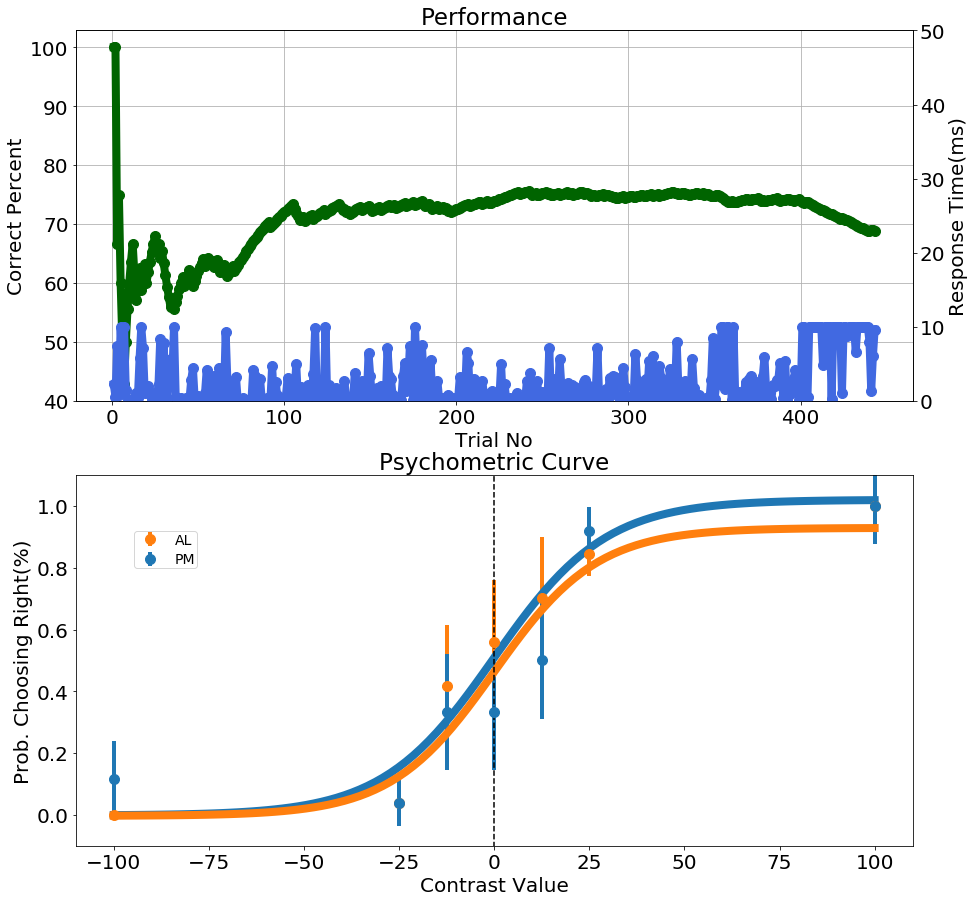

In [47]:
a.plot_session()

In [ ]:
fig=plt.figure(figsize=(15,15))
for i in range(len(sesh['wheel'])):
#     print(i)
#     t=sesh['stim_pos'].iloc[i][:,0]
    x=sesh['stim_pos'].iloc[i]
#     x=x/np.max(x)
    if sesh['answer'].iloc[i] == 1:
        plt.plot(x,'darkgreen',linewidth=3)
    elif sesh['answer'].iloc[i] == 0:
        plt.plot(x,'maroon')
    else:
        plt.plot(x,'orange')
# get_turning_points(x)

In [ ]:
i=2
x=sesh['stim_pos'].iloc[i]
#     x=x/np.max(x)
if sesh['answer'].iloc[i] == 1:
    plt.plot(x,'darkgreen',linewidth=3)
elif sesh['answer'].iloc[i] == 0:
    plt.plot(x,'maroon')
else:
    plt.plot(x,'orange')

In [19]:
class WheelBehavior():
    def __init__(self,animalid,dateinterval=None,criteria=None,verbose=False):
        self.animalid = animalid
        self.analysisfolder = '../datatest'
        self.dateinterval = dateinterval
        self.verbose = verbose
        self.prep_session_list()
        self.criteria = criteria
        
        
    def summary_exists(self,sessionpath):
        #checks if a summary file exists nand returns the file path
        #DEBUG THE PATH
        insidesesh = os.listdir(sessionpath)
        summary = [s for s in insidesesh if s.endswith('_summary.json')]
        if len(summary):
            if self.verbose:
                print('{0} found in {1}'.format(summary[0],sessionpath))
            return summary[0]
        else:
            if self.verbose:
                print('Previous summary not found')
            return None
                   
    def prep_session_list(self):
        #dateinterval is a list of two date strings e.g. ['200127','200131']
        import natsort
        session_list = [sesh for sesh in os.listdir(self.analysisfolder) if self.animalid in sesh]
        session_list = natsort.natsorted(session_list,reverse=False)
        date_list = [dt.strptime(x.split('_')[0],'%y%m%d') for x in session_list]
        
        # get the session and date list
        if self.dateinterval is None:
            if self.verbose:
                print('''No date interval given, analysing all the sessions\nStart date: {0}\nEnd date: {1}
                    '''.format(date_list[0].strftime('%d %b %Y'),date_list[-1].strftime('%d %b %Y')))
        else:
            if type(self.dateinterval) is not list:
                self.dateinterval = [self.dateinterval]
                #add end date as today
                self.dateinterval.append(dt.today().strftime('%y%m%d'))
            if len(self.dateinterval) == 2:
                startdate = dt.strptime(self.dateinterval[0],'%y%m%d')
                enddate = dt.strptime(self.dateinterval[1],'%y%m%d')
                temp = np.asarray([[session_list[i],date] for i,date in enumerate(date_list) if startdate <= date <= enddate])
                date_list = temp[:,1]
                session_list = temp[:,0]
            else:
                print('Date interval wrong!')
                
        self.session_list = session_list
        self.date_list = date_list
    
    #for now only thresholds bigger values
    def implement_criteria(self,rowtoappend):
        
        #filter data according to given criteria
        if self.criteria is None:
            print('No criteria given, including all {0} sessions'.format(len(self.session_list))) 
            return 1
        else:
            satisfied = []
            for k in self.criteria.keys():
                if k not in rowtoappend.keys():
                    print('Criteria {0} not found in data, skipping'.format(k))
                    continue
                else:
                    if rowtoappend[k] >= self.criteria[k]:
                        satisfied.append(1)
                        #TODO NEEED TO NOT RETURN BKJBSDKJQBEKDLJBQNE
                    else:
                        print('{0} not satisfied: {1} < {2}'.format(k,rowtoappend[k],self.criteria[k]))
                        satisfied.append(0)
            if 0 in satisfied:
                return 0
            else:
                return 1
                    
                
    def compile_data(self): 
        behavior_data = pd.DataFrame()
        # print('\n[WheelBehavior] Started Behavior Analysis')
        for i,sesh in enumerate(self.session_list):
            seshpath = pjoin(self.analysisfolder,sesh)
            summary_path = self.summary_exists(seshpath)
            temp = WheelSession(seshpath)
            if summary_path is not None:
                #load from summary
                session_summary = load_session_summary(pjoin(seshpath,summary_path))
            else:
                #create summary
                print('Creating summary file for {0}'.format(seshpath))
                temp.get_session_data()
                if len(temp.session_data)>0:
                    session_summary = temp.session_summary.copy()
                    temp.save_session_summary()
                    print(session_summary)
                else:
                    print('Empty session in {0}, discarding and not saving'.format(seshpath))
                    continue
            session_row = session_summary
            session_row['session_no'] = i+1
            session_row['session_date'] = self.date_list[i]
            
            # append if satisfies criteria
            if self.implement_criteria(session_row):
                behavior_data = behavior_data.append(session_row, ignore_index=True)
            else:
                continue
                
        self.behavior_data = behavior_data

        
    def extract_bias_stats(self):
        bias_mean = {}
        bias_stderr = {}
        import copy
        behavior_bias= {}
        bd = copy.deepcopy(aaa.behavior_data['bias'])
        for bias in bd:
            for k in bias.keys():
                b = bias[k].applymap(lambda y: [y])
                if k not in behavior_bias.keys():
                    behavior_bias[k] = b
                else:
                    for i in behavior_bias[k].columns:
                        if i not in b.columns:
                            b.insert(0,i,[[0],[0]])
                    n=behavior_bias[k].apply(lambda x : x + b[x.name])
                    behavior_bias[k] = n
                    
        # combine the zeros            
                    
        # the mean and stderr and flatten 
        for area in behavior_bias.keys():
            temp_mean = behavior_bias[area].applymap(np.mean)
            temp_stderr = behavior_bias[area].applymap(lambda x: np.std(x)/np.sqrt(len(x)))
            bias_mean[area] = pd.concat([temp_mean.iloc[0][::-1],temp_mean.iloc[1]])
            bias_stderr[area] = pd.concat([temp_stderr.iloc[0][::-1],temp_stderr.iloc[1]])
        
        #make the contrast axis
        contrast_axis = []
        for c in temp_mean.columns:
            contrast_axis.append(float(c)*100)
#             if float(c) != 0:
            contrast_axis.append(-1*float(c)*100)
        contrast_axis = np.sort(contrast_axis)
        
        return contrast_axis,bias_mean,bias_stderr
        
    def plot_behavior(self,savefig=False,plot_params=dict(fig_size=(15,15),
                                           font_size=20,
                                           title_size=23,
                                           line_width=8,
                                           bar_width=0.15,
                                           marker_size=10)):
        
        
        fig, axes = plt.subplots(2,1,figsize=plot_params['fig_size'])
        session_dates = self.behavior_data['session_date']
        str_session_dates = [date.strftime('%d %b %Y') for date in session_dates]
        percent_correct = self.behavior_data['correct_percent']
        response_latency = self.behavior_data['avg_latency']/1000

        ax1 = axes[0]
        ax1.plot(str_session_dates,percent_correct,'darkgreen',marker='o',
                 markersize = plot_params['marker_size'],
                 label = 'Correct Response(%)',
                 linewidth = plot_params['line_width'])
        ax1.set_xlabel('Session Dates',fontsize = plot_params['font_size'])
        ax1.tick_params(axis='x', rotation=45)
        ax1.set_ylabel('Correct Response(%)',fontsize = plot_params['font_size'])
        ax1.set_title('{0} Overall Performance'.format(self.animalid),fontsize = plot_params['font_size'])
        ax1.tick_params(axis='both',size = plot_params['font_size'])
        ax1.grid(b=True)
        ax1.tick_params(labelsize = plot_params['font_size'])
        ax12 = ax1.twinx()
        
        ax12.plot(str_session_dates,response_latency,'maroon',
                 marker='o',
                 markersize= plot_params['marker_size'],
                 label='Average Response Time(s)',
                 linewidth = plot_params['line_width'])
        ax12.tick_params(axis='y',size = plot_params['font_size'])
        ax12.set_ylabel('Average Response Time(s)', color='maroon',fontsize = plot_params['font_size'])
        ax12.grid(b=False) 
        ax1.legend(loc = [0.07,0.75],fontsize = 12,borderpad=0.1, labelspacing=0.4,prop={'size': 14})
        
        #performance with error bars for AL and PM
        ax2 = axes[1]
        contrast_axis,bias_mean,bias_stderr = self.extract_bias_stats()
        
        for k,v in bias_mean.items():

            fitted = fit2sigmoid(contrast_axis,bias_mean[k].values)
            ax2.plot(fitted[:,0],fitted[:,1],
                     c=area_colors[k],
                     linewidth=plot_params['line_width'])

            ax2.errorbar(contrast_axis,bias_mean[k].values,bias_stderr[k].values,
                         marker='o',
                         c=area_colors[k],
                         linewidth=0,
                         markersize = plot_params['marker_size'],
                         elinewidth=4,
                         label='{0}'.format(k))
        ax2.set_xlabel('Contrast Values',fontsize = plot_params['font_size'])
        ax2.tick_params(axis='x', rotation=45)
        ax2.set_ylabel('Probability of choosing Right(%)',fontsize = plot_params['font_size'])
        ax2.set_title('{0} Performance Curve'.format(self.animalid),fontsize = plot_params['font_size'])
        ax2.tick_params(axis='both',size = plot_params['font_size'])
        ax2.grid(b=True)
        ax2.tick_params(labelsize = plot_params['font_size'])
        ax2.legend(loc = [0.07,0.75],fontsize = 12,borderpad=0.1, labelspacing=0.4,prop={'size': 14})
        
        fig.suptitle('{0} Wheel Behavior'.format(self.animalid),fontsize = plot_params['title_size'])
#         fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        if savefig:
            animalfiles = os.listdir('../figures')
            
            saveloc = pjoin('../figures',self.animalid)
            if self.animalid not in animalfiles:
                os.mkdir(saveloc)
            savename = '{0}_WheelBehavior.pdf'.format(self.animalid)
            savepath = pjoin(saveloc,savename)
            fig.savefig(savepath,bbox_inches='tight')
                
                

In [20]:
criteria = dict(answered_trials=300,
                correct_percent=70)
aaa = WheelBehavior('KC018','200221',criteria=criteria)
aaa.compile_data()

The number of screen pulses 1014798 does not match the visual stimulation indicatorFlag:163368 log.
Loaded session summary from ../datatest/200221_KC018_wheel_KC/run00_shaping_stage01_pinknoise_2sftf_summary.json
The number of screen pulses 778867 does not match the visual stimulation indicatorFlag:124290 log.
Loaded session summary from ../datatest/200224_KC018_wheel_KC/run00_shaping_stage01_pinknoise_2sftf_summary.json
The number of screen pulses 1302661 does not match the visual stimulation indicatorFlag:36547 log.
Loaded session summary from ../datatest/200225_KC018_wheel_KC/run00_shaping_stage01_pinknoise_2sftf_summary.json
answered_trials not satisfied: 41 < 300
correct_percent not satisfied: 30.76923076923077 < 70
The number of screen pulses 1409395 does not match the visual stimulation indicatorFlag:41060 log.
Loaded session summary from ../datatest/200226_KC018_wheel_KC/run00_shaping_stage01_pinknoise_2sftf_summary.json
answered_trials not satisfied: 32 < 300
correct_percent n

In [21]:
aaa.behavior_data

all_trials  answered_trials  avg_latency  \
0       456.0            454.0  1010.083700   
1       379.0            377.0  1044.872679   
2       496.0            483.0  1526.200828   
3       540.0            534.0  1052.900749   
4       473.0            438.0  2072.515982   

                                                bias  correct_percent  \
0  {'AL': ['0.125', '0.25'], 'PM': ['0.125', '0.2...        76.506024   
1  {'AL': ['0.125', '0.25'], 'PM': ['0.125', '0.2...        75.689223   
2  {'AL': ['0.125', '0.25'], 'PM': ['0.125', '0.2...        71.572581   
3  {'AL': ['0.125', '0.25'], 'PM': ['0.125', '0.2...        82.962963   
4   {'AL': ['0.0', '0.125'], 'PM': ['0.0', '0.125']}        70.401691   

                                            metadata session_date  session_no  \
0  {'date': '21 Feb 20', 'rig': 't1', 'runname': ...   2020-02-21         1.0   
1  {'date': '24 Feb 20', 'rig': 't1', 'runname': ...   2020-02-24         2.0   
2  {'date': '06 Mar 20', 'rig': 't1', 'runname': ...   2020-03-06        11.0   
3  {'date': '10 Mar 20', 'rig': 't1', 'runname': ...   2020-03-10        13.0   
4  {'date': '11 Mar 20', 'rig': 't1', 'runname': ...   2020-03-11        14.0   

               trial_dstr  
0  {'AL': 228, 'PM': 226}  
1  {'AL': 189, 'PM': 188}  
2  {'AL': 242, 'PM': 241}  
3  {'AL': 271, 'PM': 263}  
4  {'AL': 221, 'PM': 217}

In [ ]:
import copy
behavior_bias= {}
bd = copy.deepcopy(aaa.behavior_data['bias'])
for bias in bd:
    for k in bias.keys():
        b = bias[k].applymap(lambda y: [y])
        if k not in behavior_bias.keys():
            behavior_bias[k] = b
        else:
            for i in behavior_bias[k].columns:
                if i not in b.columns:
                    b.insert(0,i,[[0],[0]])
            n=behavior_bias[k].apply(lambda x : x + b[x.name])
            behavior_bias[k] = n
behavior_bias

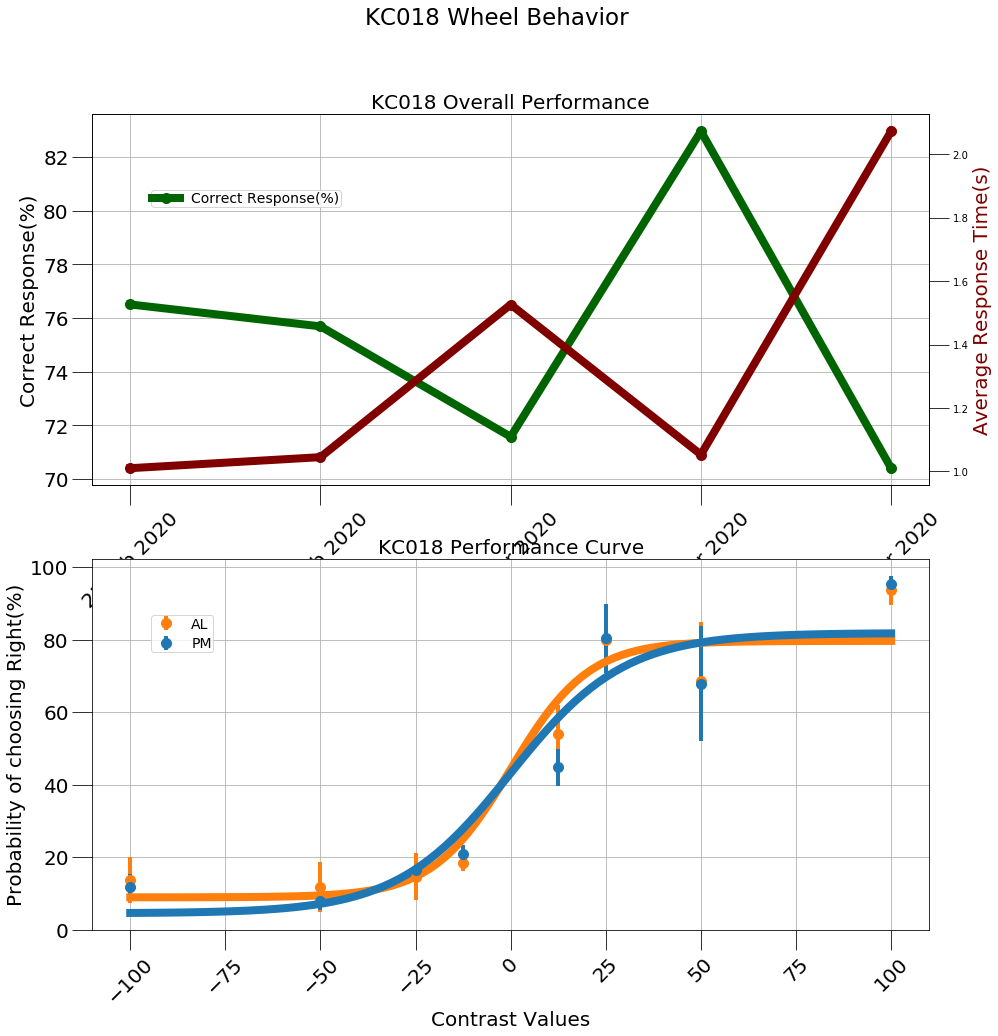

In [22]:
f=aaa.plot_behavior(savefig=True)